In [1]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 17.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV

from dmba import classificationSummary

import matplotlib.pyplot as plt


no display found. Using non-interactive Agg backend


## Load the data and fit the model

In [4]:
# The data are in a 'sample_data' directory
DATA_DIR_PATH = 'drive/MyDrive/AMSD/M1/S1/dataI/Data I/evaluating classification models'
DATA_DIR_PATH

'drive/MyDrive/AMSD/M1/S1/dataI/Data I/evaluating classification models'

### Load loan data

In [5]:
LOAN_DATA_CSV = 'loan_data.csv'
loan_data = pd.read_csv(os.path.join(DATA_DIR_PATH, LOAN_DATA_CSV))
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


### Logistic regression

In [6]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, 
                               solver='liblinear')
logit_reg.fit(X, y)

LogisticRegression(C=1e+42, solver='liblinear')

In [7]:
print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380882883923482
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


## Confusion matrix

The confusion matrix is a table showing the number of correct and incorrect predictions categorized by type of response. In the following, we will consider a *logistic regression* model that was trained on a balanced data set with an equal number of defaulted and paid-off loans.<br>

**Convention** Y=1 corresponds to the event of interest and Y = 0 corresponds to a negative (or usual) event.



In [8]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = np.array([1 if x=='default' else 0 for x in pred])
print("# pred_y\t", pred_y[:10])
print("# ~pred_y\t", ~pred_y[:10])

# NB: 
# the ~ invert a binary number; this corresponds to ~n = -n-1
# Hence:
# 0 = False = -2 = ~-1
# 1 = True = -1 = ~-2

true_y = y == 'default'
print("# true_y\t", true_y.tolist()[:10])
print("# ~true_y\t", (~true_y).tolist()[:10])

# pred_y	 [0 0 1 1 0 1 0 1 1 0]
# ~pred_y	 [-1 -1 -2 -2 -1 -2 -1 -2 -2 -1]
# true_y	 [True, True, True, True, True, True, True, True, True, True]
# ~true_y	 [False, False, False, False, False, False, False, False, False, False]


In [9]:
#print(type(true_y))
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

print("# true_pos\t", true_pos.tolist()[:10])
print("# true_neg\t", true_neg.tolist()[:10])
print("# false_pos\t", false_pos.tolist()[:10])
print("# false_neg\t", false_neg.tolist()[:10])

# true_pos	 [False, False, True, True, False, True, False, True, True, False]
# true_neg	 [False, False, False, False, False, False, False, False, False, False]
# false_pos	 [False, False, False, False, False, False, False, False, False, False]
# false_neg	 [True, True, False, False, True, False, True, False, False, True]


In [10]:
conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], 
                         [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [11]:
# An alternative counting method

# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
TP = np.sum(np.logical_and(pred_y == 1, true_y == 1))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(pred_y == 0, true_y == 0))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(pred_y == 1, true_y == 0))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(pred_y == 0, true_y == 1))
 

In [12]:
conf_mat = pd.DataFrame([[np.sum(TP), np.sum(FN)], 
                         [np.sum(FP), np.sum(TN)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [13]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]


## Precision, Recall, and Specificity
The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score and support. 

In [14]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision\t{:.4f}'.format(conf_mat[0, 0] / sum(conf_mat[:, 0])))
print('Recall\t{:.4f}'.format(conf_mat[0, 0] / sum(conf_mat[0, :])))
print('Specificity\t{:.4f}'.format(conf_mat[1, 1] / sum(conf_mat[1, :])))

Precision	0.6376
Recall	0.6323
Specificity	0.6406


In [15]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

## ROC Curve
The function `roc_curve` in _Scikit-learn_ calculates all the information that is required for plotting a ROC curve.

In [16]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

## AUC
Accuracy can easily be calculated using the _scikit-learn_ function `accuracy_score`.

In [17]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


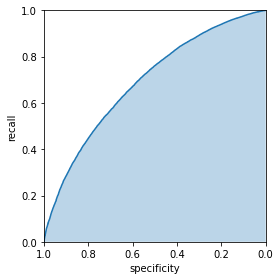

In [18]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()